# Convolutional Neural Network
#### FOUNDATION OF DEEP LEARNING

*Master Degree in Data Science* <br>
*University of Milano-Bicocca* <br> <br> 

Filippo Algeri 828825, Marta Brasola 905305, Maurizio Papa 870316

In [1]:
#ignore warnings
import warnings
import time 
warnings.filterwarnings("ignore", category= UserWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

#plots
import matplotlib.pyplot as plt
import seaborn as sns

##download data
from IPython.display import FileLink

# CNN
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses
import keras

from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, Reshape, SpatialDropout1D, Conv1D, Dropout, Bidirectional, GRU, BatchNormalization, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model

import pydot

# Import data

In [2]:
train = pd.read_csv('/kaggle/input/fdl-arxiv-final/train_resampled.csv')
test = pd.read_csv('/kaggle/input/fdl-arxiv-final/test.csv')

### Shuffle
#### Train

In [3]:
rng = np.random.default_rng(seed=42)
shuffler1 = rng.permutation(train.shape[0])

In [4]:
X_train = train['abstract'].values
X_train = [X_train[i] for i in shuffler1]

y_train = train['labels'].values
y_train = [y_train[i] for i in shuffler1]

#### Test

In [5]:
shuffler2 = rng.permutation(test.shape[0])

In [6]:
X_test = test['abstract'].values
X_test = [X_test[i] for i in shuffler2]

y_test = test['labels'].values
y_test = [y_test[i] for i in shuffler2]

In [7]:
#data representation using TfidfVectorizer() as vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=4000, use_idf=True)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(f'''X_train_tfidf shape: {X_train_tfidf.shape}''')
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f'''X_test_tfidf shape: {X_test_tfidf.shape}''')

tf_len = len(tfidf_vectorizer.vocabulary_)

X_train_tfidf shape: (44440, 4000)
X_test_tfidf shape: (27320, 4000)


# CNN (Convutional Neural Network)

In [8]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

After several attempts this is the final architecture:

In [9]:
input = Input(batch_shape=(None, tf_len, ))

resh = Reshape((tf_len, 1), input_shape=(tf_len, ))(input)

conv20 = Conv1D(filters=128, kernel_size=5, activation='relu')(resh)
drop20 = Dropout(0.4)(conv20)

conv21 = Conv1D(filters=64, kernel_size=5, activation='relu')(drop20)
bach21 = BatchNormalization()(conv21)

pool21 = MaxPooling1D(pool_size=2)(conv21)
drop21 = Dropout(0.4)(pool21)

flat22 = Flatten()(drop21)
out = Dense(8, activation='softmax')(flat22)

model = Model(input, out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4000)]            0         
                                                                 
 reshape (Reshape)           (None, 4000, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 3996, 128)         768       
                                                                 
 dropout (Dropout)           (None, 3996, 128)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3992, 64)          41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1996, 64)         0         
 )                                                               
                                                             

In [10]:
epochs = 10
batch_size = 128
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

# Fit the model using the train and test datasets.
history = model.fit(X_train_tfidf.toarray(), y_train,
                    validation_data= (X_test_tfidf.toarray(),y_test),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[callback])

model.save('CNN-TFIDF')

Epoch 1/10
348/348 [==============================] - 55s 116ms/step - loss: 0.7986 - accuracy: 0.7317 - val_loss: 0.5540 - val_accuracy: 0.8282
Epoch 2/10
348/348 [==============================] - 43s 123ms/step - loss: 0.5420 - accuracy: 0.8148 - val_loss: 0.5505 - val_accuracy: 0.8305
Epoch 3/10
348/348 [==============================] - 40s 115ms/step - loss: 0.4814 - accuracy: 0.8335 - val_loss: 0.5845 - val_accuracy: 0.8218
Epoch 4/10
348/348 [==============================] - 43s 125ms/step - loss: 0.4461 - accuracy: 0.8449 - val_loss: 0.5871 - val_accuracy: 0.8201
Epoch 5/10
348/348 [==============================] - 43s 125ms/step - loss: 0.4165 - accuracy: 0.8552 - val_loss: 0.5908 - val_accuracy: 0.8243
Epoch 6/10
348/348 [==============================] - 43s 125ms/step - loss: 0.3912 - accuracy: 0.8632 - val_loss: 0.5643 - val_accuracy: 0.8343
Epoch 7/10
348/348 [==============================] - 43s 124ms/step - loss: 0.3593 - accuracy: 0.8735 - val_loss: 0.5910 - val_ac

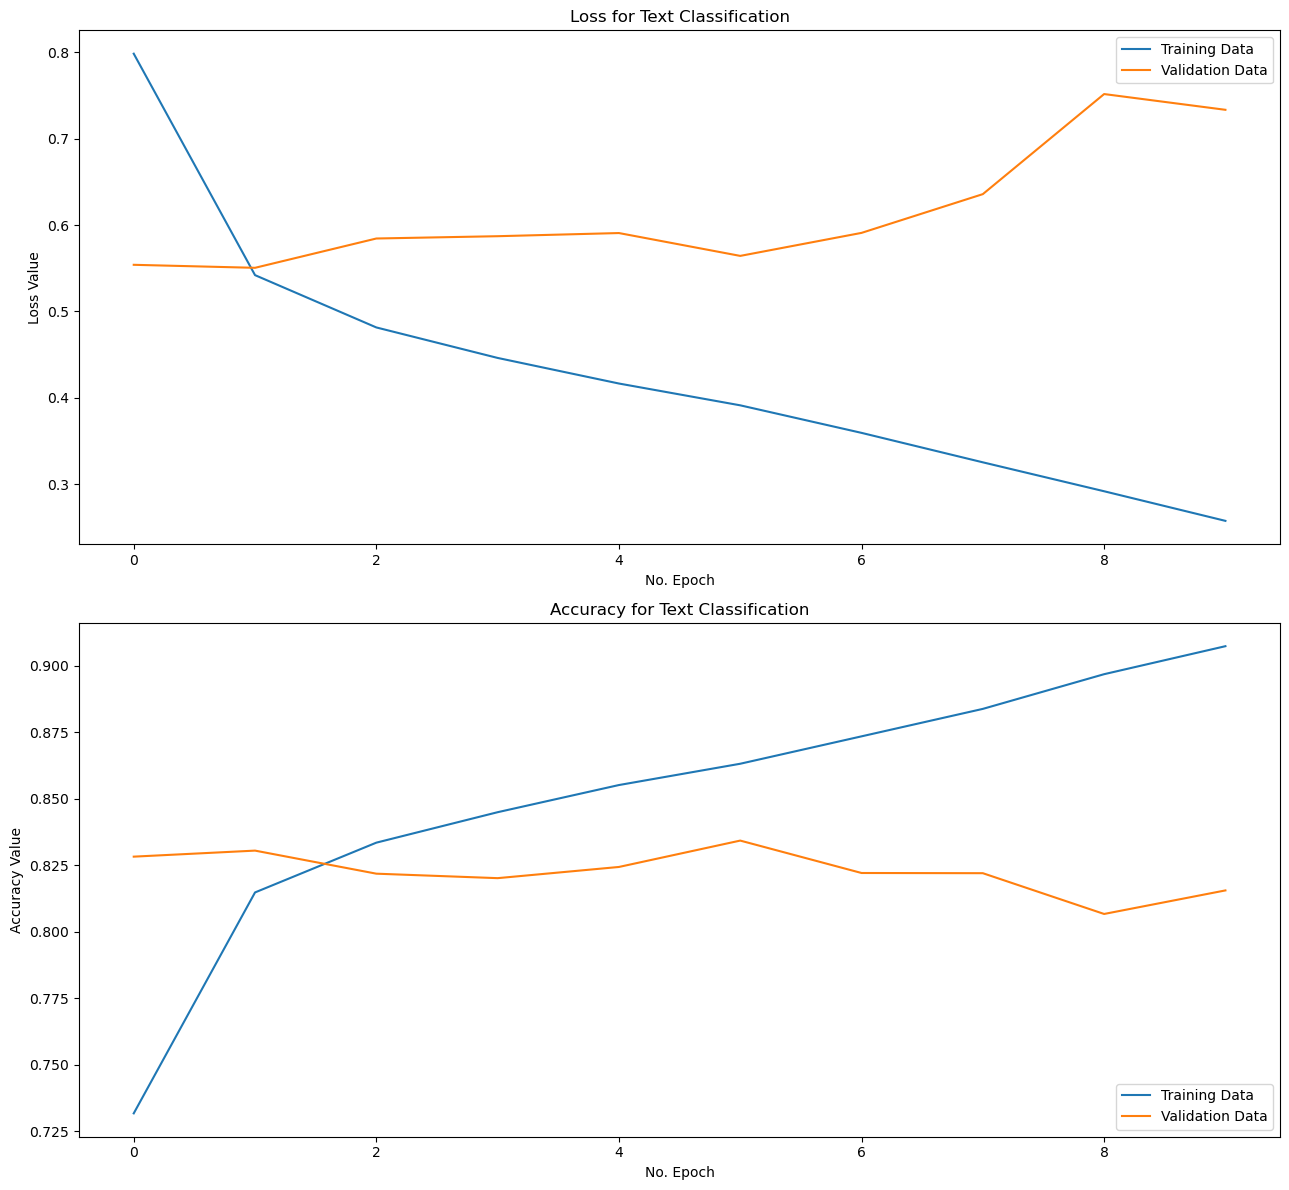

In [11]:
plt.figure(figsize=(13, 12))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Data')
plt.plot(history.history['val_loss'], label='Validation Data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss Value')
plt.xlabel('No. Epoch')
plt.legend(loc='upper right')

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Data')
plt.plot(history.history['val_accuracy'], label='Validation Data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy Value')
plt.xlabel('No. Epoch')
plt.legend(loc='lower right')
plt.tight_layout()

plt.savefig('results_CNN_TFIDF')

plt.show()

In [12]:
#!zip -r CNN_TFIDF.zip /kaggle/working/CNN-TFIDF